# ANOVA – comfort ratings

This notebook analyzes subjective comfort ratings with a repeated-measures design.

Within-subject factors:
- stimulus type (Classic vs Gabor)
- contrast level

Before running:
- Set the `ROOT` path below to your local directory
- This notebook assumes that questionnaire rating have been filled in (`Results/questionnaire/questionnaire_answers.csv`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import os

ROOT = r"C:\Users\donja\Desktop\Thesis"
CSV = rf"{ROOT}\Results\questionnaire\questionnaire_answers.csv"
FIG_DIR = os.path.join(ROOT, "Results")
os.makedirs(FIG_DIR, exist_ok=True)

df = pd.read_csv(CSV)
df.head()

,subject,stim_type,contrast,comfort,tiring,distracting
0,sub-002,classic,10,2.2,6.4,2.2
1,sub-002,classic,20,1.2,1.0,3.5
2,sub-002,classic,30,1.1,5.0,3.5
3,sub-002,classic,40,5.9,2.4,3.7
4,sub-002,classic,60,6.7,0.6,9.4


In [2]:
for col in ["comfort", "tiring", "distracting"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

assert df[["comfort", "tiring", "distracting"]].min().min() >= 0
assert df[["comfort", "tiring", "distracting"]].max().max() <= 10

df["comfort_comp"] = df[["comfort", "tiring", "distracting"]].mean(axis=1)

In [3]:
#Check whether combining is justified
alpha, _ = pg.cronbach_alpha(df[["comfort", "tiring", "distracting"]])
print("Cronbach's alpha:", alpha)

Cronbach's alpha: 0.8466446077623679


In [4]:
anova_comfort_comp = pg.rm_anova(
    dv="comfort_comp",
    within=["stim_type", "contrast"],
    subject="subject",
    data=df,
    detailed=True
)
anova_comfort_comp

C:\Users\donja\miniconda3\envs\thesis_env\lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\donja\miniconda3\envs\thesis_env\lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,stim_type,212.189352,1,4,212.189352,33.262864,0.004486,0.004486,0.611180,1.000000
1,contrast,19.172833,5,20,3.834567,2.573260,0.059266,0.159797,0.124367,0.296386
2,stim_type * contrast,9.593426,5,20,1.918685,1.512430,0.230536,0.281596,0.066352,0.335444


In [5]:
df.groupby("stim_type")["comfort_comp"].agg(["mean", "std", "count"])

,mean,std,count
stim_type,,,
classic,4.697778,2.037915,30
grating,8.458889,1.222167,30


## Visualization of comfort ratings

The following plots visualize mean comfort ratings across stimulus types and
contrast levels. Error bars indicate within-subject variability (where applicable).

These figures are used for qualitative interpretation alongside the statistical results.

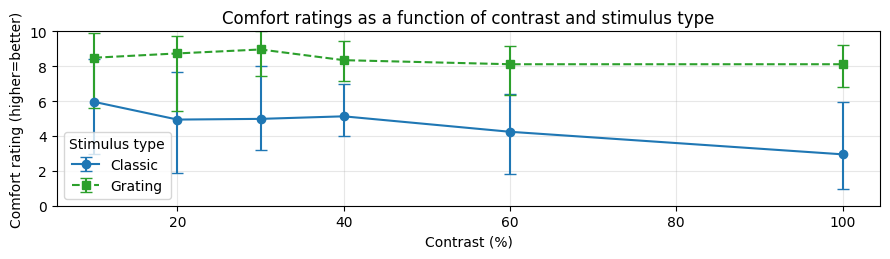

In [6]:
plt.style.use("default")
plt.figure(figsize=(9, 2.7))

contrasts = sorted(df["contrast"].unique().astype(int))

for stim in ["classic", "grating"]:
    d = df[df["stim_type"] == stim]

    stats = (
        d.groupby("contrast")["comfort_comp"]
        .agg(mean="mean", min="min", max="max")
        .reindex(contrasts)
    )

    means = stats["mean"].to_numpy()

    yerr = np.vstack([
        stats["mean"] - stats["min"],  
        stats["max"] - stats["mean"]   
    ])

    if stim == "classic":
        plt.errorbar(contrasts, means, yerr=yerr, marker="o", linestyle="-", color="C0", capsize=4, label="Classic")
    else:
        plt.errorbar(contrasts, means, yerr=yerr, marker="s", linestyle="--", color="C2", capsize=4, label="Grating")
        
plt.xlabel("Contrast (%)")
plt.ylabel("Comfort rating (higher=better)")
plt.title("Comfort ratings as a function of contrast and stimulus type")
plt.grid(alpha=0.3)
plt.ylim(0,10)
plt.legend(title="Stimulus type")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "comfort_vs_contrast.pdf"),dpi=300,bbox_inches="tight")
plt.show()

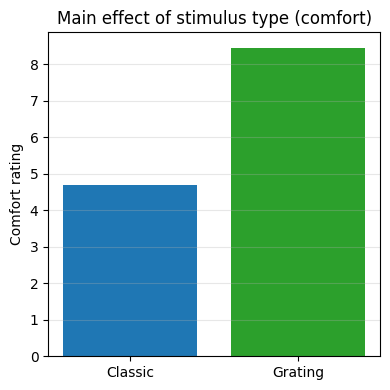

In [7]:
means = df.groupby("stim_type")["comfort_comp"].mean()

plt.figure(figsize=(4, 4))
plt.bar(["Classic", "Grating"], means.values, color=["C0", "C2"])
plt.ylabel("Comfort rating")
plt.title("Main effect of stimulus type (comfort)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

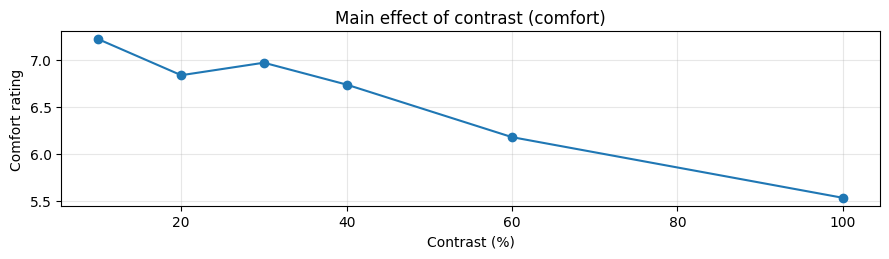

In [8]:
means_contrast = (df.groupby("contrast")["comfort_comp"].mean().sort_index())

plt.figure(figsize=(9, 2.7))
plt.plot(means_contrast.index.astype(int),means_contrast.values,marker="o",linestyle="-",color="C0")
plt.xlabel("Contrast (%)")
plt.ylabel("Comfort rating")
plt.title("Main effect of contrast (comfort)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

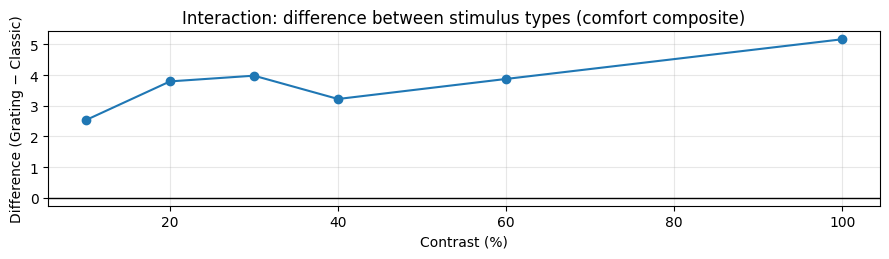

In [9]:
df_mean = (df.groupby(["subject", "stim_type", "contrast"], as_index=False)
             ["comfort_comp"].mean())

df_pivot = df_mean.pivot_table(index=["subject", "contrast"],
                               columns="stim_type",
                               values="comfort_comp")

df_pivot["diff_g_minus_c"] = df_pivot["grating"] - df_pivot["classic"]
mean_diff = df_pivot.groupby("contrast")["diff_g_minus_c"].mean().sort_index()

plt.figure(figsize=(9, 2.7))
plt.plot(mean_diff.index.astype(int), mean_diff.values, marker="o", linestyle="-")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Contrast (%)")
plt.ylabel("Difference (Grating − Classic)")
plt.title("Interaction: difference between stimulus types (comfort composite)")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()